<a href="https://colab.research.google.com/github/arinadubinich/NeuralNetworks-spring2020/blob/master/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dubinich Arina, PM-41

Task 1


In [0]:
import keras
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers.core import Activation

In [0]:
train_path = 'drive/My Drive/dataset/train/'
validation_path = 'drive/My Drive/dataset/validation/'

In [0]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
train_generator=train_datagen.flow_from_directory(train_path,
  target_size=(224,224), 
  color_mode='rgb',
  batch_size=32, 
  class_mode='categorical',
  shuffle=True)

Found 700 images belonging to 10 classes.


In [7]:
validation_generator=train_datagen.flow_from_directory(validation_path,
  target_size=(224,224), 
  color_mode='rgb',
  batch_size=32, 
  class_mode='categorical',
  shuffle=True)

Found 100 images belonging to 10 classes.


In [11]:
base_model=MobileNet(weights='imagenet',include_top=False)
output_model=base_model.output
output_model=GlobalAveragePooling2D()(output_model)
output_model=Dense(1024,activation='relu')(output_model)
output_model=Dense(512,activation='relu')(output_model)
output_model=Dense(10,activation='softmax')(output_model)

model=Model(inputs=base_model.input,outputs=output_model)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
for layer in base_model.layers:
  layer.trainable=True

In [0]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid=validation_generator.n//validation_generator.batch_size

In [20]:
history_non_trainable = model.fit_generator(generator=train_generator,
  steps_per_epoch=step_size_train,
  validation_data=validation_generator,
  validation_steps =step_size_valid,
  epochs=10)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


 1/21 [>.............................] - ETA: 14:51 - loss: 2.7958 - accuracy: 0.0625

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/21 [=>............................] - ETA: 13:47 - loss: 3.2465 - accuracy: 0.0938

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/21 [===>..........................] - ETA: 12:30 - loss: 2.9247 - accuracy: 0.1667

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/21 [====>.........................] - ETA: 11:40 - loss: 2.9083 - accuracy: 0.2188

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/21 [======>.......................] - ETA: 10:53 - loss: 2.8135 - accuracy: 0.2438

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/21 [=======>......................] - ETA: 10:48 - loss: 2.5847 - accuracy: 0.2917

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/21 [=========>....................] - ETA: 10:06 - loss: 2.4593 - accuracy: 0.2991

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/21 [==========>...................] - ETA: 9:14 - loss: 2.2949 - accuracy: 0.3281 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/21 [===========>..................] - ETA: 8:23 - loss: 2.1839 - accuracy: 0.3646

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/21 [=============>................] - ETA: 7:37 - loss: 2.1018 - accuracy: 0.3688

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/21 [==============>...............] - ETA: 6:53 - loss: 1.9967 - accuracy: 0.4034

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/21 [================>.............] - ETA: 6:09 - loss: 1.9054 - accuracy: 0.4297

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/21 [=================>............] - ETA: 5:22 - loss: 1.8583 - accuracy: 0.4296

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/21 [===================>..........] - ETA: 4:40 - loss: 1.8035 - accuracy: 0.4459

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/21 [====================>.........] - ETA: 3:59 - loss: 1.7429 - accuracy: 0.4622

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/21 [=====================>........] - ETA: 3:18 - loss: 1.6923 - accuracy: 0.4823

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/21 [=======================>......] - ETA: 2:38 - loss: 1.6269 - accuracy: 0.5056

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/21 [========================>.....] - ETA: 1:58 - loss: 1.5871 - accuracy: 0.5192

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/21 [==========================>...] - ETA: 1:18 - loss: 1.5261 - accuracy: 0.5397

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


20/21 [===========================>..] - ETA: 39s - loss: 1.4880 - accuracy: 0.5456 

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/21 [==============================] - 827s 39s/step - loss: 1.4423 - accuracy: 0.5569 - val_loss: 0.2639 - val_accuracy: 0.9062
Epoch 2/10
21/21 [==============================] - 71s 3s/step - loss: 0.4122 - accuracy: 0.8757 - val_loss: 0.3751 - val_accuracy: 0.8529
Epoch 3/10
21/21 [==============================] - 43s 2s/step - loss: 0.2316 - accuracy: 0.9222 - val_loss: 0.2767 - val_accuracy: 0.9412
Epoch 4/10
21/21 [==============================] - 43s 2s/step - loss: 0.1590 - accuracy: 0.9536 - val_loss: 0.1509 - val_accuracy: 0.9265
Epoch 5/10
21/21 [==============================] - 45s 2s/step - loss: 0.0658 - accuracy: 0.9835 - val_loss: 0.3611 - val_accuracy: 0.8854
Epoch 6/10
21/21 [==============================] - 43s 2s/step - loss: 0.1337 - accuracy: 0.9626 - val_loss: 0.5743 - val_accuracy: 0.8088
Epoch 7/10
21/21 [==============================] - 43s 2s/step - loss: 0.0551 - accuracy: 0.9865 - val_loss: 0.1347 - val_accuracy: 0.9412
Epoch 8/10
21/21 [===========

In [24]:
history_trainable = model.fit_generator(generator=train_generator,
  steps_per_epoch=step_size_train,
  validation_data=validation_generator,
  validation_steps =step_size_valid,
  epochs=3)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/3
21/21 [==============================] - 44s 2s/step - loss: 0.0116 - accuracy: 0.9985 - val_loss: 0.3005 - val_accuracy: 0.9271
Epoch 2/3
21/21 [==============================] - 43s 2s/step - loss: 0.0276 - accuracy: 0.9910 - val_loss: 0.1814 - val_accuracy: 0.9265
Epoch 3/3
21/21 [==============================] - 43s 2s/step - loss: 0.0165 - accuracy: 0.9940 - val_loss: 0.0663 - val_accuracy: 0.9412


In [26]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


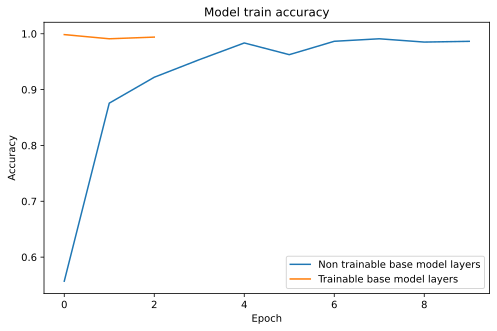

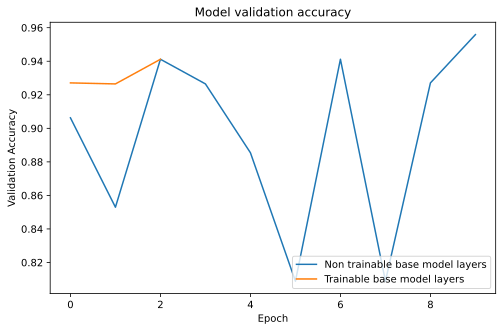

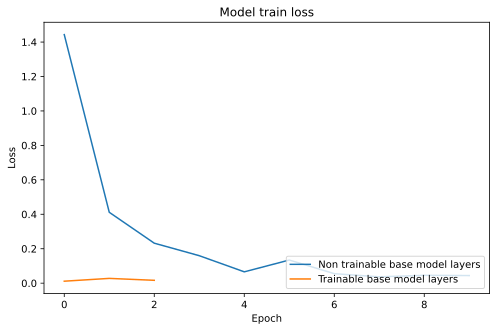

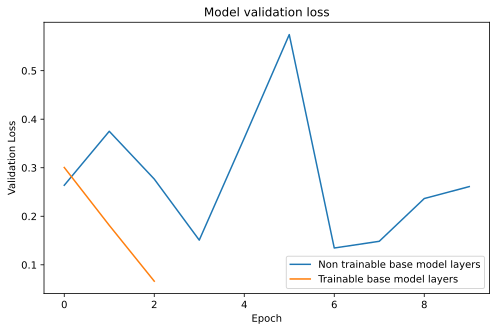

In [30]:
plt.plot(history_non_trainable.history['accuracy'])
plt.plot(history_trainable.history['accuracy'])
plt.title('Model train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Non trainable base model layers', 'Trainable base model layers'], loc='lower right')
plt.show()

plt.plot(history_non_trainable.history['val_accuracy'])
plt.plot(history_trainable.history['val_accuracy'])
plt.title('Model validation accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['Non trainable base model layers', 'Trainable base model layers'], loc='lower right')
plt.show()

plt.plot(history_non_trainable.history['loss'])
plt.plot(history_trainable.history['loss'])
plt.title('Model train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Non trainable base model layers', 'Trainable base model layers'], loc='lower right')
plt.show()

plt.plot(history_non_trainable.history['val_loss'])
plt.plot(history_trainable.history['val_loss'])
plt.title('Model validation loss')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend(['Non trainable base model layers', 'Trainable base model layers'], loc='lower right')
plt.show()

Task 2

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


In [0]:
#MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

In [0]:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [0]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [0]:
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [0]:
# Shape info needed to build Decoder Model
shape = K.int_shape(x)

In [0]:
# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [0]:
# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
# Stack of Transposed Conv2D blocks
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)
x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

In [0]:
# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_21 (Conv2DT (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0   

In [0]:
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
autoencoder.compile(loss='mse', optimizer='adam')

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train the autoencoder
history = autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0609 - val_loss: 0.0328
Epoch 2/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0259 - val_loss: 0.0219
Epoch 3/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0210 - val_loss: 0.0197
Epoch 4/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0193 - val_loss: 0.0185
Epoch 5/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0183 - val_loss: 0.0178
Epoch 6/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0176 - val_loss: 0.0174
Epoch 7/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 8/30
60000/60000 [==============================] - 88s 1ms/step - loss: 0.0168 - val_loss: 0.0169
Epoch 9/30
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0165 - val_loss: 0.0167
Epoch

In [0]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

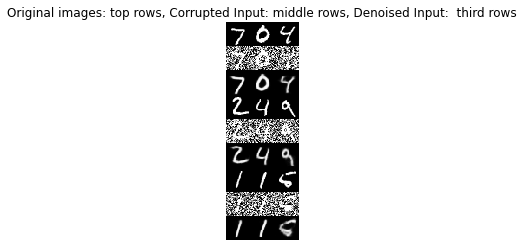

In [0]:
rows, cols = 3, 3
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()